# LogReg

In [272]:
import pandas as pd
from sklearn.metrics import classification_report, auc, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(r'C:\Users\Даниил\Desktop\abalone\abalone_csv.csv')
df['Male'] = (df.Sex == 'M') * 1
df['Female'] = (df.Sex == 'F') * 1
df['Infant'] = (df.Sex == 'I') * 1
df.drop('Sex', axis=1, inplace=True)
df['Class_number_of_rings'] = df.Class_number_of_rings * 1.

In [42]:
df['Class_number_of_rings'].value_counts()

9.0     689
10.0    634
8.0     568
11.0    487
7.0     391
12.0    267
6.0     259
13.0    203
14.0    126
5.0     115
15.0    103
16.0     67
17.0     58
4.0      57
18.0     42
19.0     32
20.0     26
3.0      15
21.0     14
23.0      9
22.0      6
27.0      2
24.0      2
1.0       1
26.0      1
2.0       1
29.0      1
25.0      1
Name: Class_number_of_rings, dtype: int64

In [43]:
for i in range(9):
    df = df.drop(df[(df.Class_number_of_rings == i)].index)
        
for i in range(11, 30):
    df = df.drop(df[(df.Class_number_of_rings == i)].index)
df['Class_number_of_rings'].value_counts()

9.0     689
10.0    634
Name: Class_number_of_rings, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop('Class_number_of_rings', axis = 1).values
Y = df['Class_number_of_rings'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X_train.shape

(992, 10)

In [48]:
%%time

from sklearn.linear_model import LogisticRegression


lr=LogisticRegression()
lr.fit(X_train,Y_train)
Y_pred=lr.predict(X_test)


print(classification_report(Y_test, Y_pred))
print("Roc-auc score:", roc_auc_score(Y_test, Y_pred))

              precision    recall  f1-score   support

         9.0       0.57      0.76      0.65       153
        10.0       0.71      0.49      0.58       178

    accuracy                           0.62       331
   macro avg       0.64      0.63      0.62       331
weighted avg       0.64      0.62      0.61       331

Roc-auc score: 0.6295439524124256
Wall time: 9 ms


C:\anac\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Полносвязная сеть

In [49]:
for i in range(len(Y_test)):
    if Y_test[i] == 9.:
        Y_test[i] = 0
    else:
        Y_test[i] = 1.

        
for i in range(len(Y_train)):
    if Y_train[i] == 9.:
        Y_train[i] = 0
    else:
        Y_train[i] = 1.


In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [396]:
class fmodel(nn.Module):
    def __init__(self):
        super(fmodel, self).__init__()
        self.layer0 = nn.Linear(10, 10)
        self.layer1 = nn.Linear(10, 80)
        self.layer2 = nn.Linear(80, 50)
        self.layer3 = nn.Linear(50, 1)
    
    def forward(self, x):
        x0 = self.layer0(x)
        x1 = F.relu(self.layer1(x0))
        x1 = nn.Dropout(p=0.1)(x1)
        x2 = F.relu(self.layer2(x1))
        x2 = nn.Dropout(p=0.1)(x2)
        x3 = F.sigmoid(self.layer3(x2))
        return x3
    
    

In [397]:
def train(model, criterion, optimizer, num_epochs=25):
    tr_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        if epoch % 40 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        model.train()
        loss = 0.
        optimizer.zero_grad()
        for i in range(len(X_train)):
            x = torch.Tensor(X_train[i])
            y = torch.Tensor([Y_train[i]])
            prediction = model.forward(x)
            loss += criterion(prediction.view(1, -1), y.view(1, -1))
        loss.backward()
        optimizer.step()
        tr_losses.append(loss.item() / len(X_train))
        if epoch % 40 == 0:
            print("train_loss:", loss.item() / len(X_train))
        
        loss = 0.
        model.eval()
        with torch.no_grad():
            for i in range(len(X_test)):
                x = torch.Tensor(X_test[i])
                y = torch.Tensor([Y_test[i]])
                prediction = model.forward(x)
                loss += criterion(prediction.view(1, -1), y.view(1, -1))
                
        val_losses.append(loss.item() / len(X_test))
        if epoch % 40 == 0:
            print("val_loss:", loss.item() / len(X_test))  
        if (loss.item() / len(X_test)) == min(val_losses):
            torch.save(model.state_dict(), "./best_model.pth")
    
    model.load_state_dict(torch.load("./best_model.pth"))
    model.eval()
    plt.figure(figsize=(10,6))
    plt.plot([i for i in range(num_epochs)], tr_losses, label="train")
    plt.plot([i for i in range(num_epochs)], val_losses, label="validation")
    plt.xlabel('epoch', fontsize=15)
    plt.ylabel('loss', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

In [398]:
model = fmodel()
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

Epoch 0/149
----------


C:\anac\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train_loss: 0.6953109002882435
val_loss: 0.6880376533439152
Epoch 40/149
----------
train_loss: 0.6610515963646674
val_loss: 0.6707622608749528
Epoch 80/149
----------
train_loss: 0.6482012348790323
val_loss: 0.6575994578012887
Epoch 120/149
----------
train_loss: 0.647569102625693
val_loss: 0.6397033414811887


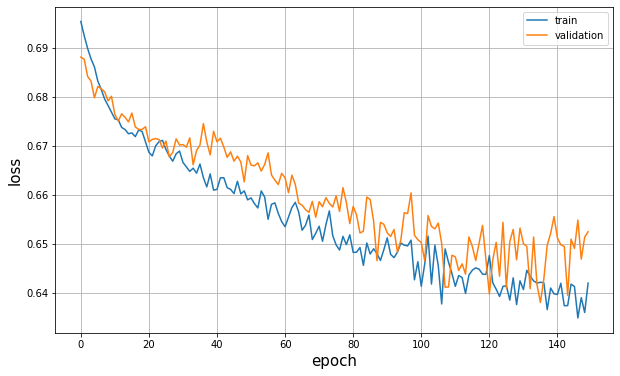

Wall time: 1min 40s


In [399]:
%%time
train(model, criterion, optimizer, num_epochs=150)

In [401]:
predictions = []
for i in X_test:
    prediction = model.forward(torch.Tensor(i))
    predictions.append(prediction.item())

    
r_predictions = []
for i in predictions:
    r_predictions.append(round(i))
    
print(classification_report(Y_test, r_predictions))
print("Roc-auc score:", roc_auc_score(Y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.57      0.78      0.66       153
         1.0       0.72      0.49      0.58       178

    accuracy                           0.63       331
   macro avg       0.65      0.64      0.62       331
weighted avg       0.65      0.63      0.62       331

Roc-auc score: 0.6867885731071455


C:\anac\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
